In [71]:
import torch
import torch_directml
import matplotlib.pyplot as plt
import numpy as np

from torchvision.transforms import v2
from matplotlib.patches import Rectangle
from model import mobilevig
from PIL import Image

In [72]:
device = torch_directml.device()
model = mobilevig.mobilevig_ti().to(device)

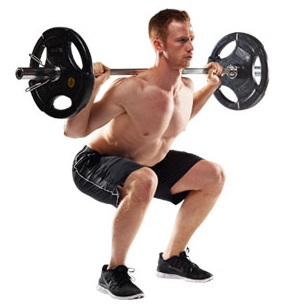

In [73]:
image = Image.open("./dataset/Squat/squat_23.jpg")

image

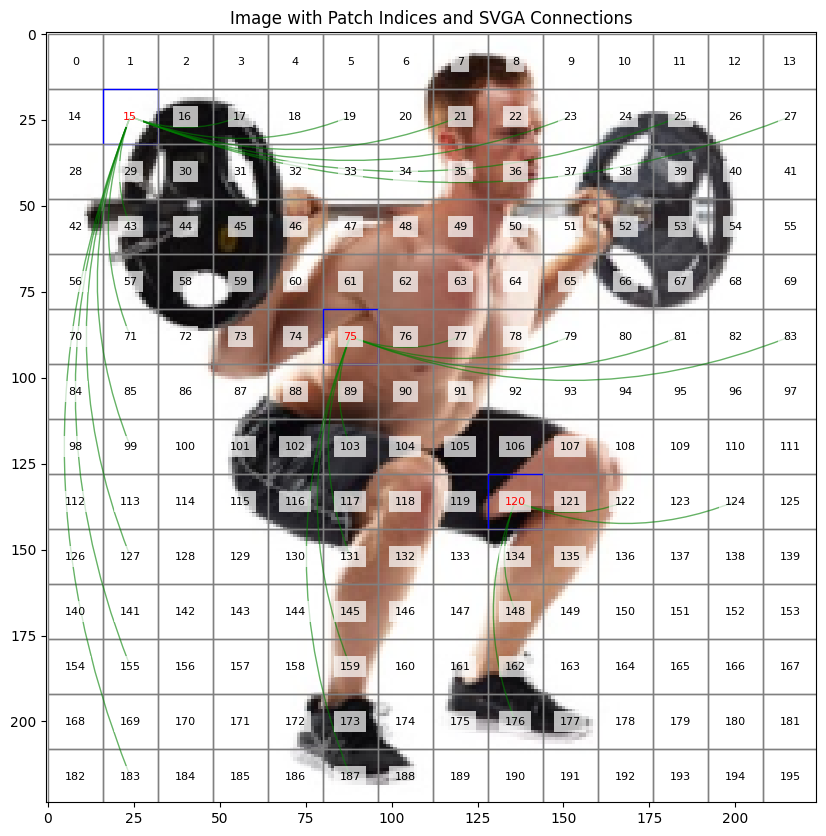

In [82]:
def visualize_svga_with_patches(image, patch_size, k, node_indices):
    # Convert image tensor to numpy array
    image_np = image.cpu().squeeze().permute(1, 2, 0).numpy()
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.imshow(image_np)
    img_height, img_width, _ = image_np.shape
    num_patches_row = img_width // patch_size
    num_patches_col = img_height // patch_size

    # Draw patches and their indices
    for row in range(num_patches_col):
        for col in range(num_patches_row):
            patch_index = row * num_patches_row + col
            x, y = col * patch_size, row * patch_size
            rect = Rectangle(
                (x, y),
                patch_size,
                patch_size,
                linewidth=1,
                edgecolor="blue" if patch_index in node_indices else "gray",
                facecolor="none",
            )
            ax.add_patch(rect)
            ax.text(
                x + patch_size / 2,
                y + patch_size / 2,
                f"{patch_index}",
                color="red" if patch_index in node_indices else "black",
                ha="center",
                va="center",
                fontsize=8,
                bbox=dict(facecolor='white', alpha=0.7, edgecolor='none')
            )

    # Draw connections for SVGA
    for idx, node_index in enumerate(node_indices):
        main_x, main_y = patch_index_to_coords(node_index, patch_size, img_width)
        for offset in range(1, max(num_patches_row, num_patches_col)):
            if offset % k == 0:
                # Right connection
                if (node_index % num_patches_row) + offset < num_patches_row:
                    connected_index = node_index + offset
                    nx, ny = patch_index_to_coords(connected_index, patch_size, img_width)
                    connection = FancyArrowPatch(
                        (main_y + patch_size / 2, main_x + patch_size / 2),
                        (ny + patch_size / 2, nx + patch_size / 2),
                        connectionstyle="arc3,rad=0.2",
                        color="green",
                        alpha=0.6,
                        arrowstyle="-",
                    )
                    ax.add_patch(connection)

                # Downward connection
                if (node_index // num_patches_row) + offset < num_patches_col:
                    connected_index = node_index + (offset * num_patches_row)
                    nx, ny = patch_index_to_coords(connected_index, patch_size, img_width)
                    connection = FancyArrowPatch(
                        (main_y + patch_size / 2, main_x + patch_size / 2),
                        (ny + patch_size / 2, nx + patch_size / 2),
                        connectionstyle="arc3,rad=0.2",
                        color="green",
                        alpha=0.6,
                        arrowstyle="-",
                    )
                    ax.add_patch(connection)

    plt.title("Image with Patch Indices and SVGA Connections")
    plt.show()

# Helper function to convert patch index to coordinates
def patch_index_to_coords(index, patch_size, img_width):
    num_patches_per_row = img_width // patch_size
    row = index // num_patches_per_row
    col = index % num_patches_per_row
    return row * patch_size, col * patch_size

# Preprocess the image
preprocess = v2.Compose(
    [
        v2.ToPILImage(),
        v2.Resize((224, 224)),  # Resize to 224x224
        v2.ToTensor(),
    ]
)

# Example usage
image_tensor = preprocess(image).unsqueeze(dim=0).to(device)  # Replace 'image' with your image tensor

# Parameters
patch_size = 16  # Example patch size
k = 2  # Number of connections for SVGA graph
node_indices = [15, 75, 120]  # Example node indices to visualize

# Visualize the nodes with their SVGA connections and patch grid
visualize_svga_with_patches(image_tensor, patch_size, k, node_indices)